# Hull and Qiao Approach
*Xiaoqiong(Joan) Zhang*

1. The worksheet contains data that can be used to construct a number of predictors.  These include:

•	The E/P ratio (column D divided by column B)

•	The term spread (column I minus column F)

•	The default spread (column H minus column G)

•	Net issuance (column J)

•	The sheet also contains market returns in column Q and risk-free returns in column K.  Use them to compute the excess return on the market.  

The dependent variable is the excess market return.

2. Guidelines:

•	All regressions should use exactly 10 years of data.  So your first prediction will be made in December of 1959.  You will be predicting the January 1960 return.  Move the sample forward one month and repeat.  (Differently from H&Q, the dependent variable should be the one month return.)

•	Use what H&Q call the “kitchen sink” approach.  In other words, do put all four predictors in your regressions. 

•	If m(t) is your return excess forecast at time t, then set your portfolio weight equal to 
w(t) = min{1.5, max{-.5, 100×m(t)}}.
Note that the 100 is a lot different than the 8 used by H&Q.  I am assuming that your market excess return forecasts will not be annualized.  So if your expected return in the next month is .01 (a 1% return in the next month or 12% annualized), then you would put all of your money in the market index.

•	Given the weight w(t), your portfolio’s excess return in time t+1 will therefore be w(t) r(t+1), where r is the actual excess market return.

•	As with H&Q, assess both strategies using mean, standard deviation, and Sharpe.  Report corresponding values for the strategy that simply puts 100% into the market.

3. Extension Strategies

Initial Correlation Screening, Real-time Correlation Screening, LASSO Model

In [1]:
import pandas as pd
import numpy as np

In [12]:
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('PredictorData2017.xlsx',sheet_name='Monthly',usecols="A,B,D,F,G,H,I,J,Q,K",names=['A','B','D','F','G','H','I','J','K','Q'])

df['Date'] = pd.to_datetime(df['A'],format='%Y%m')
df = df.set_index('Date')
df = df.drop('A',axis=1)
df = df.to_period('M')
df1 = df.truncate(before=pd.Timestamp('1949-12'))
df1.head()

,B,D,F,G,H,I,J,K,Q
Date,,,,,,,,,
1949-12,16.76,2.32000,0.0110,0.0258,0.0331,0.0209,0.027175,0.000917,0.050984
1950-01,17.05,2.33667,0.0107,0.0257,0.0324,0.0215,0.027102,0.000892,0.019703
1950-02,17.22,2.35333,0.0112,0.0258,0.0324,0.0214,0.025491,0.000933,0.019603
1950-03,17.29,2.37000,0.0112,0.0258,0.0324,0.0215,0.029291,0.000933,0.008185
1950-04,18.07,2.42667,0.0115,0.0260,0.0323,0.0214,0.026396,0.000958,0.045887


In [3]:
data = pd.DataFrame(index=df1.index)

data['E_P_ratio'] = df1['D']/df1['B']
data['term_spread'] = df1['I']-df1['F']
data['default_spread'] = df1['H'] - df1['G']
data['net_insurrance'] = df1['J']
data['risk_free'] = df1['K']
data['market_excess_ret'] = df1['Q'] - df1['K']
data['reg_returns'] = data['market_excess_ret'].shift(-1)

In [4]:
data.head()

,E_P_ratio,term_spread,default_spread,net_insurrance,risk_free,market_excess_ret,reg_returns
Date,,,,,,,
1949-12,0.138425,0.0099,0.0073,0.027175,0.000917,0.050067,0.018811
1950-01,0.137048,0.0108,0.0067,0.027102,0.000892,0.018811,0.018670
1950-02,0.136663,0.0102,0.0066,0.025491,0.000933,0.018670,0.007252
1950-03,0.137073,0.0103,0.0066,0.029291,0.000933,0.007252,0.044929
1950-04,0.134293,0.0099,0.0063,0.026396,0.000958,0.044929,0.045935


## Strategy
1. Using 10-years data to predicted the next monthly return.
2. The weights of portfolio depends on the predicted return.
3. Get the return of portfolio
4. Access the strategy and compare it with simple strategy that holds 100% market 

*The first prediction will be made in December of 1959 to predict the January 1960 return. 
Then move the sample forward one month and repeat.*

In [5]:
# Regression function
import statsmodels.formula.api as smf

def regression(data):
    reg_df = data[:-1]
    pred_df = data[-1:]
    model = smf.ols('reg_returns ~ E_P_ratio + term_spread + default_spread + net_insurrance',data=reg_df).fit()
    prediction = model.predict(pred_df)
    return prediction

def rollingwins(x,min_periods):
    return [x[i-min_periods:i+1] for i in range(min_periods,x.shape[0])]

# My extension: what if it's a expanding windows?
def expwins(x,min_periods):
    return [x[:i] for i in range(min_periods,x.shape[0])]

In [6]:
# My extension: what if it's a expanding windows?
# Predictions
min_periods = 12*10
inputs = data[['reg_returns','E_P_ratio','term_spread','default_spread','net_insurrance']]
wins = expwins(inputs, min_periods = min_periods)

predictions = [regression(win)[0] for win in wins]
predictions = pd.DataFrame(predictions,index = data.index[min_periods :],columns=['predicted_ret'])

In [7]:
# Rolling windows Predictions: use exactly 10 years of data
min_periods = 12*10
inputs = data[['reg_returns','E_P_ratio','term_spread','default_spread','net_insurrance']]
wins = rollingwins(inputs,min_periods = min_periods)

In [8]:
m_t = [regression(win)[0] for win in wins]
m_t_data = pd.DataFrame(m_t,index = data.index[min_periods :],columns=['predicted_ret'])

In [9]:
m_t_data.head(10)

,predicted_ret
Date,
1959-12,-0.001440
1960-01,-0.003744
1960-02,-0.000083
1960-03,0.004234
1960-04,0.007139
1960-05,0.007222
1960-06,0.016694
1960-07,0.012475
1960-08,0.014316


In [14]:
compare_data = data.truncate(before='1959-12')
compare_data['pred_excess_ret'] = m_t

In [15]:
compare_data.head()

,E_P_ratio,term_spread,default_spread,net_insurrance,risk_free,market_excess_ret,reg_returns,pred_excess_ret
Date,,,,,,,,
1959-12,0.056604,-0.0002,0.0070,0.022857,0.003742,0.025885,-0.073558,-0.001440
1960-01,0.060960,0.0006,0.0073,0.022116,0.003625,-0.073558,0.010622,-0.003744
1960-02,0.060406,0.0033,0.0078,0.024038,0.003300,0.010622,-0.015324,-0.000083
1960-03,0.061258,0.0080,0.0076,0.025593,0.002758,-0.015324,-0.018805,0.004234
1960-04,0.061554,0.0103,0.0075,0.025576,0.002692,-0.018805,0.030771,0.007139


Text(0, 0.5, 'predicted excess ret')

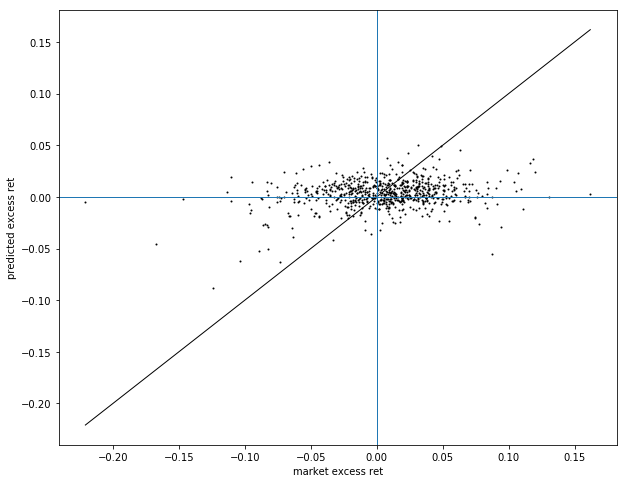

In [16]:
fig = plt.figure(figsize=(10,8))
plt.scatter(compare_data['market_excess_ret'],compare_data['pred_excess_ret'],1,c='k')
x = np.linspace(min(compare_data['market_excess_ret']),max(compare_data['market_excess_ret']),50)
plt.plot(x,x,linewidth=1,c='k')
plt.axhline(linewidth=1)
plt.axvline(linewidth=1)
plt.xlabel('market excess ret')
plt.ylabel('predicted excess ret')

Use what H&Q call the “kitchen sink” approach.  In other words, do put all four predictors in the regressions.  

If m(t) is the return excess forecast at time t, then set the portfolio weight equal to 
w(t) = min{1.5, max{-.5, 100×m(t)}}.


In [17]:
w_t = 100*m_t_data
w_t['predicted_ret'][w_t['predicted_ret']<-0.5] = -0.5
w_t['predicted_ret'][w_t['predicted_ret']>1.5] = 1.5

print('The maximum w(t) is ', w_t.max())
print('The minimum w(t) is ', w_t.min())

w_t.values[:5]

The maximum w(t) is  predicted_ret    1.5
dtype: float64
The minimum w(t) is  predicted_ret   -0.5
dtype: float64


array([[-0.14397059],
       [-0.37442764],
       [-0.00825697],
       [ 0.42335069],
       [ 0.71390739]])

Given the weight w(t), the portfolio’s excess return in time t+1 will therefore be w(t) r(t+1), where r is the actual excess market return.

In [18]:
market_excess_ret = data.truncate(before=pd.Timestamp('1960-01'))['market_excess_ret']

port_excess_ret = w_t['predicted_ret'].shift(1)*market_excess_ret

compare_data['weight'] = w_t['predicted_ret']
compare_data['port_excess_ret'] =port_excess_ret
compare_data.head()

,E_P_ratio,term_spread,default_spread,net_insurrance,risk_free,market_excess_ret,reg_returns,pred_excess_ret,weight,port_excess_ret
Date,,,,,,,,,,
1959-12,0.056604,-0.0002,0.0070,0.022857,0.003742,0.025885,-0.073558,-0.001440,-0.143971,NaN
1960-01,0.060960,0.0006,0.0073,0.022116,0.003625,-0.073558,0.010622,-0.003744,-0.374428,0.010590
1960-02,0.060406,0.0033,0.0078,0.024038,0.003300,0.010622,-0.015324,-0.000083,-0.008257,-0.003977
1960-03,0.061258,0.0080,0.0076,0.025593,0.002758,-0.015324,-0.018805,0.004234,0.423351,0.000127
1960-04,0.061554,0.0103,0.0075,0.025576,0.002692,-0.018805,0.030771,0.007139,0.713907,-0.007961


In [19]:
# Assessment
def describePerformance(Data):
    x = Data.describe()
    x.drop(['25%','75%'], inplace=True)
    x.loc['sharpe']  = x.loc['mean'] / x.loc['std'] * np.sqrt(12)
    x.loc['fracpos'] = (Data>=0).mean()
    return x

In [20]:
X = compare_data[['market_excess_ret','port_excess_ret']][1:]

In [21]:
print('The Performace of Strategy :','\n',describePerformance(X))

The Performace of Strategy : 
          market_excess_ret  port_excess_ret
count           696.000000       696.000000
mean              0.005119         0.004054
std               0.042302         0.033006
min              -0.220903        -0.149543
50%               0.008269         0.001711
max               0.161896         0.174127
sharpe            0.419198         0.425500
fracpos           0.587644         0.540230


In [22]:
performance = pd.DataFrame(port_excess_ret,columns=['port_excess_ret'],index=port_excess_ret.index)
performance['market_excess_ret'] = market_excess_ret

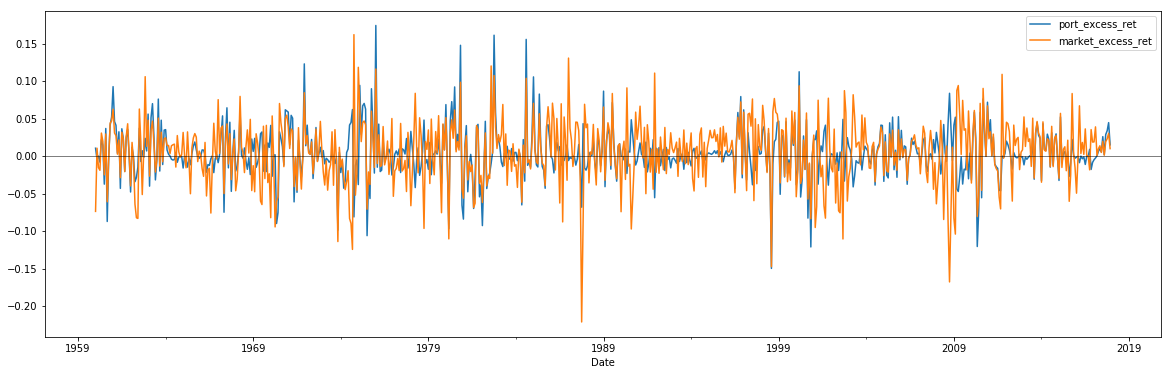

In [23]:
performance.plot(figsize=(20,6))
plt.axhline(c='k',linewidth=0.5)

In [24]:
Value = 100*(X+1).cumprod()

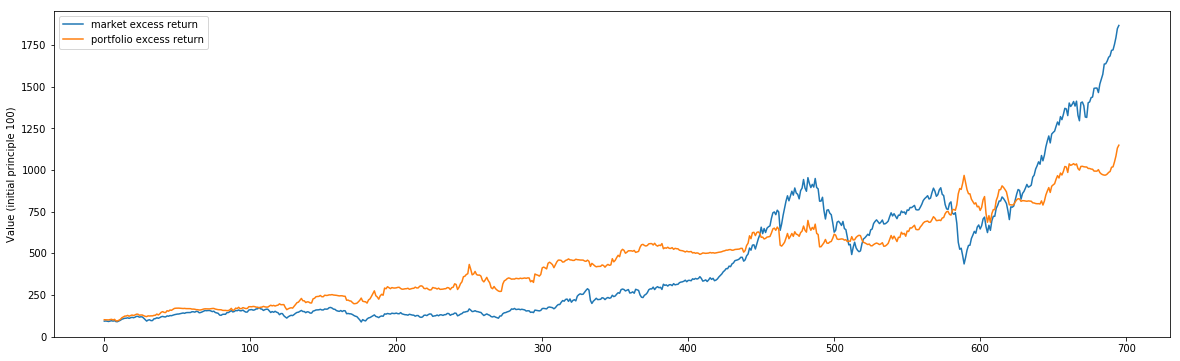

In [25]:
plt.figure(figsize=(20,6))
plt.plot(Value['market_excess_ret'].values,label='market excess return')
plt.plot(Value['port_excess_ret'].values,label='portfolio excess return')
plt.ylabel('Value (initial principle 100)')
plt.legend()

## Optional Strategy 1
*Adding correlation screening to select variables at the first step*

In [26]:
data2 = data[['reg_returns','E_P_ratio','term_spread','default_spread','net_insurrance']][0:10*12+1]

In [27]:
cor = data2.corr()
cor['reg_returns']

reg_returns       1.000000
E_P_ratio         0.146736
term_spread       0.312965
default_spread    0.032587
net_insurrance   -0.196582
Name: reg_returns, dtype: float64

All four variables are needed to be selected after initial correlation screaning. So this stragety has the same performance with kitchen sink.

## Optional Strategy 2
*Adding real-time correlation screening to select variables*

In [28]:
import statsmodels.api as sm
def regression_corr_screening(data):
    # correlation screening
    cor = data.corr()
    data2 = data[cor[abs(cor['reg_returns'])<0.01].index]
    data2['reg_returns'] = data['reg_returns']
    
    reg_df = data2[:-1]
    reg_y = reg_df['reg_returns']
    reg_x = sm.add_constant(reg_df.drop('reg_returns',axis=1))

    pred_df = data2[-1:]
    x = np.array(pred_df.drop('reg_returns',axis=1)).reshape(1,-1)
    pred_x = np.insert(x,0,[1])
    
    model = sm.OLS(reg_y,reg_x).fit()
    prediction = model.predict(pred_x)
    return prediction

In [29]:
# Rolling windows with correlation screening Predictions: use exactly 10 years of data
min_periods = 12*10
inputs = data[['reg_returns','E_P_ratio','term_spread','default_spread','net_insurrance']]
wins = rollingwins(inputs,min_periods = min_periods)

m_t_corr_s = [regression_corr_screening(win)[0] for win in wins]
m_t_corr_s_data = pd.DataFrame(m_t_corr_s,index = data.index[min_periods :],columns=['predicted_ret'])

/Users/xiaoqiongzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
m_t_corr_s_data.head()

,predicted_ret
Date,
1959-12,0.013806
1960-01,0.013036
1960-02,0.012969
1960-03,0.012781
1960-04,0.012250


In [31]:
w_t_cs = 100*m_t_corr_s_data
w_t_cs['predicted_ret'][w_t_cs['predicted_ret']<-0.5] = -0.5
w_t_cs['predicted_ret'][w_t_cs['predicted_ret']>1.5] = 1.5

In [32]:
print('The maximum w(t) is ', w_t_cs.max())
print('The minimum w(t) is ', w_t_cs.min())

w_t_cs.values[:5]

The maximum w(t) is  predicted_ret    1.485591
dtype: float64
The minimum w(t) is  predicted_ret   -0.5
dtype: float64


array([[1.38056694],
       [1.3035925 ],
       [1.29688611],
       [1.27807278],
       [1.22496167]])

In [33]:
market_excess_ret = data.truncate(before=pd.Timestamp('1960-01'))['market_excess_ret']

port_excess_ret = w_t_cs['predicted_ret'].shift(1)*market_excess_ret

stragety_data = pd.DataFrame(index = compare_data.index)
stragety_data['market_excess_ret'] = compare_data['market_excess_ret']
stragety_data[['s0_w','s0_port_excess_ret']] = compare_data[['weight','port_excess_ret']]
stragety_data['s2_w'] = w_t_cs
stragety_data['s2_port_excess_ret'] = port_excess_ret

stragety_data.head()

,market_excess_ret,s0_w,s0_port_excess_ret,s2_w,s2_port_excess_ret
Date,,,,,
1959-12,0.025885,-0.143971,NaN,1.380567,NaN
1960-01,-0.073558,-0.374428,0.010590,1.303593,-0.101552
1960-02,0.010622,-0.008257,-0.003977,1.296886,0.013847
1960-03,-0.015324,0.423351,0.000127,1.278073,-0.019874
1960-04,-0.018805,0.713907,-0.007961,1.224962,-0.024034


In [34]:
X = stragety_data[['market_excess_ret','s0_port_excess_ret','s2_port_excess_ret']]
Value = 100*(1+X).cumprod()

In [35]:
print('The Performace of Strategy :','\n',describePerformance(X[1:]))

The Performace of Strategy : 
          market_excess_ret  s0_port_excess_ret  s2_port_excess_ret
count           696.000000          696.000000          696.000000
mean              0.005119            0.004054            0.002073
std               0.042302            0.033006            0.026147
min              -0.220903           -0.149543           -0.164913
50%               0.008269            0.001711            0.001853
max               0.161896            0.174127            0.101066
sharpe            0.419198            0.425500            0.274659
fracpos           0.587644            0.540230            0.567529


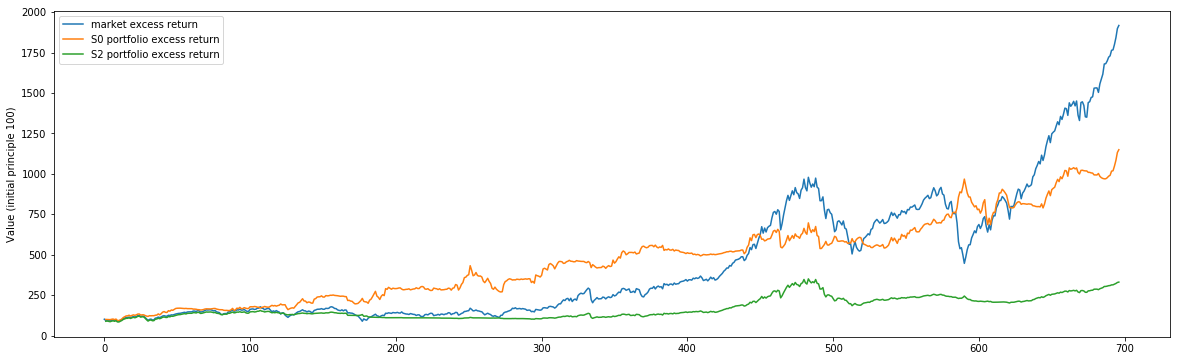

In [36]:
plt.figure(figsize=(20,6))
plt.plot(Value['market_excess_ret'].values,label='market excess return')
plt.plot(Value['s0_port_excess_ret'].values,label='S0 portfolio excess return')
plt.plot(Value['s2_port_excess_ret'].values,label='S2 portfolio excess return')
plt.ylabel('Value (initial principle 100)')
plt.legend()

## Optional Strategy 3
*Using LASSO*

In [37]:
from sklearn.linear_model import Lasso

In [38]:
def regression_lasso(data):
    reg_df = data[:-1]
    reg_y = reg_df['reg_returns']
    reg_x = reg_df.drop('reg_returns',axis=1)
    
    pred_df = data[-1:]
    pred_x = pred_df.drop('reg_returns',axis=1)
    
    model = Lasso(alpha=0.1).fit(reg_x,reg_y)
    prediction = model.predict(pred_x)
    return prediction

In [39]:
# Rolling windows Predictions: use exactly 10 years of data
min_periods = 12*10
inputs = data[['reg_returns','E_P_ratio','term_spread','default_spread','net_insurrance']]
wins = rollingwins(inputs,min_periods = min_periods)

In [40]:
m_t_3 = [regression_lasso(win)[0] for win in wins]
m_t_3_data = pd.DataFrame(m_t_3,index = data.index[min_periods :],columns=['predicted_ret'])

In [41]:
m_t_3_data.head()

,predicted_ret
Date,
1959-12,0.013806
1960-01,0.013036
1960-02,0.012969
1960-03,0.012781
1960-04,0.012250


In [42]:
w_t_3 = 100*m_t_3_data
w_t_3['predicted_ret'][w_t_3['predicted_ret']<-0.5] = -0.5
w_t_3['predicted_ret'][w_t_3['predicted_ret']>1.5] = 1.5

In [43]:
print('The maximum w(t) is ', w_t_3.max())
print('The minimum w(t) is ', w_t_3.min())

w_t_cs.values[:5]

The maximum w(t) is  predicted_ret    1.380567
dtype: float64
The minimum w(t) is  predicted_ret   -0.418305
dtype: float64


array([[1.38056694],
       [1.3035925 ],
       [1.29688611],
       [1.27807278],
       [1.22496167]])

In [44]:
market_excess_ret = data.truncate(before=pd.Timestamp('1960-01'))['market_excess_ret']

port_excess_ret = w_t_3['predicted_ret'].shift(1)*market_excess_ret

stragety_data['s3_w'] = w_t_3
stragety_data['s3_port_excess_ret'] = port_excess_ret
stragety_data.head()

,market_excess_ret,s0_w,s0_port_excess_ret,s2_w,s2_port_excess_ret,s3_w,s3_port_excess_ret
Date,,,,,,,
1959-12,0.025885,-0.143971,NaN,1.380567,NaN,1.380567,NaN
1960-01,-0.073558,-0.374428,0.010590,1.303593,-0.101552,1.303592,-0.101552
1960-02,0.010622,-0.008257,-0.003977,1.296886,0.013847,1.296886,0.013847
1960-03,-0.015324,0.423351,0.000127,1.278073,-0.019874,1.278073,-0.019874
1960-04,-0.018805,0.713907,-0.007961,1.224962,-0.024034,1.224962,-0.024034


In [45]:
X = stragety_data[['market_excess_ret','s0_port_excess_ret','s2_port_excess_ret','s3_port_excess_ret']]
Value = 100*(1+X).cumprod()

In [46]:
print('The Performace of Strategy :','\n',describePerformance(X[1:]))

The Performace of Strategy : 
          market_excess_ret  s0_port_excess_ret  s2_port_excess_ret  \
count           696.000000          696.000000          696.000000   
mean              0.005119            0.004054            0.002073   
std               0.042302            0.033006            0.026147   
min              -0.220903           -0.149543           -0.164913   
50%               0.008269            0.001711            0.001853   
max               0.161896            0.174127            0.101066   
sharpe            0.419198            0.425500            0.274659   
fracpos           0.587644            0.540230            0.567529   

         s3_port_excess_ret  
count            696.000000  
mean               0.002496  
std                0.025547  
min               -0.164913  
50%                0.001971  
max                0.101066  
sharpe             0.338415  
fracpos            0.568966  


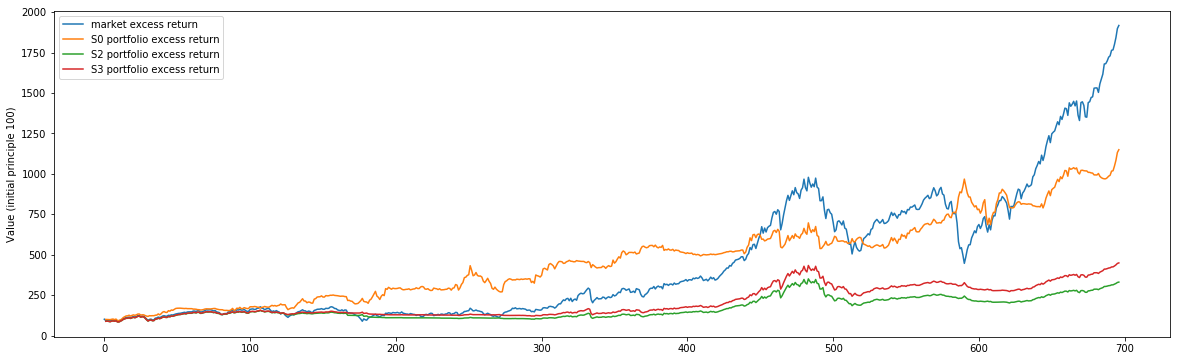

In [47]:
plt.figure(figsize=(20,6))
plt.plot(Value['market_excess_ret'].values,label='market excess return')
plt.plot(Value['s0_port_excess_ret'].values,label='S0 portfolio excess return')
plt.plot(Value['s2_port_excess_ret'].values,label='S2 portfolio excess return')
plt.plot(Value['s3_port_excess_ret'].values,label='S3 portfolio excess return')
plt.ylabel('Value (initial principle 100)')
plt.legend()